# Importing Libraries

In [1]:
import os
import cv2
import csv
import glob
import pandas as pd
import numpy as np
import random
import itertools
from collections import Counter
from math import ceil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In this kernel, I present some utility functions to do some sanity check on images, as well as some functions that you can reuse for future projects when you want to plot multiple images in a grid. A sneak peek of how a multiple bounding box plot is as such:

![sample](https://i.ibb.co/9GXMpWT/img.png)

**References**

- [Paperspace DataAugmentationForObjectDetection](https://github.com/Paperspace/DataAugmentationForObjectDetection)

- [ateplyuk's gwd starter](https://www.kaggle.com/ateplyuk/gwd-starter-efficientdet-train)

# Utilities

Utility functions are stored here, they are useful and feel free to add these into your arsenal.

In [2]:
def skip_csv_header(file):
    has_header = csv.Sniffer().has_header(file.read(1024))
    file.seek(0)
    if has_header:
        next(file)


def total_image_list(image_folder_path):
    total_img_list = [os.path.basename(img_path_name) for img_path_name in glob.glob(os.path.join(image_folder_path, "*.jpg"))]
    return total_img_list

def draw_rect(img, bboxes, color=None):
    img = img.copy()
    bboxes = bboxes[:, :4]
    bboxes = bboxes.reshape(-1, 4)
    for bbox in bboxes:
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        img = cv2.rectangle(img.copy(), pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=ceil(len(img_matrix_list) / ncols), ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

# Reading and Loading the Dataset

In [3]:
train = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")  
image_folder_path = "/kaggle/input/global-wheat-detection/train/"

I personally like to expand the bounding box coordinates into the form of **x_min, y_min, x_max, y_max**, but currently they are stored in a list of **[x_min,y_min, width of bbox, height of bbox]**. So the next portion will help to expand them out. **This is a personal preference, in actual fact you do not need to do this, it is easier for me to normalize the bboxes**.

In [4]:
train['bbox'] = train['bbox'].apply(lambda x: x[1:-1].split(","))
train['x_min'] = train['bbox'].apply(lambda x: x[0]).astype('float32')
train['y_min'] = train['bbox'].apply(lambda x: x[1]).astype('float32')
train['width'] = train['bbox'].apply(lambda x: x[2]).astype('float32')
train['height'] = train['bbox'].apply(lambda x: x[3]).astype('float32')
train = train[['image_id','x_min', 'y_min', 'width', 'height']]
train["x_max"] = train.apply(lambda col: col.x_min + col.width, axis=1)
train["y_max"] = train.apply(lambda col: col.y_min + col.height, axis = 1)
train.head()

image_id  x_min  y_min  width  height  x_max  y_max
0  b6ab77fd7  834.0  222.0   56.0    36.0  890.0  258.0
1  b6ab77fd7  226.0  548.0  130.0    58.0  356.0  606.0
2  b6ab77fd7  377.0  504.0   74.0   160.0  451.0  664.0
3  b6ab77fd7  834.0   95.0  109.0   107.0  943.0  202.0
4  b6ab77fd7   26.0  144.0  124.0   117.0  150.0  261.0

# Range Checking on Bounding Box Coordinates

Furthermore, due to python's internal floating problems, there may be weird values like negative or values that adds up to be more than 1024 in `x_max, y_max`. We need to be careful here. 

**This is a serious problem that one can run into when you Normalize the bounding box, it may exceed 1 and this will cause an error especially if you decide to augment the images as well.**

In [5]:
train[train["x_max"] > 1024]
train[train["y_max"] > 1024]
train[train["x_min"] < 0]
train[train["y_min"] < 0]

image_id       x_min  y_min       width      height        x_max  \
31785  fda86ae9a  873.200012   10.4  150.800003  186.000000  1024.000015   
61189  b70c20580  994.400024  770.0   29.600000   29.799999  1024.000025   

            y_max  
31785  196.400000  
61189  799.799999

image_id       x_min       y_min      width      height       x_max  \
43087  da5063a1b  464.799988  894.400024  58.200001  129.600006  522.999989   

             y_max  
43087  1024.000031

Empty DataFrame
Columns: [image_id, x_min, y_min, width, height, x_max, y_max]
Index: []

Empty DataFrame
Columns: [image_id, x_min, y_min, width, height, x_max, y_max]
Index: []

The sole reason that for eg row 31785 has `x_max` more than 1024 is because of the original dataset's labelling. Let's look at the respective problematic rows. For example, in row 31785, the `x_min` provided is 873.200012, and when you add that to the width being 150.800003, it gives you 1024.000015, which exceeds the image size already. So you have to round down. And as far as I feel, bounding boxes, when de-normalized, should necessary be in integer. But this is just my opinion. Let's change these problematic values to 1024

In [6]:
x_max = np.array(train["x_max"].values.tolist())
y_max = np.array(train["y_max"].values.tolist())
train["x_max"] = np.where(x_max > 1024, 1024, x_max).tolist()
train["y_max"] = np.where(y_max > 1024, 1024, y_max).tolist()

We can delete width and height columns because we do not need them, it can be easily pulled out from the images itself.

In [7]:
del train["width"]
del train["height"]
train.head()

image_id  x_min  y_min  x_max  y_max
0  b6ab77fd7  834.0  222.0  890.0  258.0
1  b6ab77fd7  226.0  548.0  356.0  606.0
2  b6ab77fd7  377.0  504.0  451.0  664.0
3  b6ab77fd7  834.0   95.0  943.0  202.0
4  b6ab77fd7   26.0  144.0  150.0  261.0

I assign a class "1" which is the label wheat. It may be useful later on should we wish to add in images with no wheat inside the image.

In [8]:
train["class"] = "1"

# Check if image extensions are all jpg

First, we check if all images in the train folder are all in **.jpg** format. It is better to check because if there are a mixture of image type, we may face troubles later on.

In [9]:
def check_file_type(image_folder_path):
    extension_type = []
    file_list = os.listdir(image_folder_path)
    for file in file_list:
        extension_type.append(file.rsplit(".", 1)[1].lower())
    print(Counter(extension_type).keys())
    print(Counter(extension_type).values())
    
check_file_type(image_folder_path)

dict_keys(['jpg'])
dict_values([3422])


Good, seems like all our images in the folder are of **.jpg** format. Next, it is better to append **.jpg** behind all the **image_id** in the dataframe. This will make us manipulate the data easier later.

In [10]:
## replace image_id with .jpg behind the image_id
# image_id_list = train["image_id"].tolist()
# image_id_append_jpg = []
# for image_id in image_id_list:
#     image_id_append_jpg.append(image_id + ".jpg")
# train["image_id"] = image_id_append_jpg
# train.head()


## Alternatively like Rohit suggested, an one liner will do the trick

train["image_id"] = train["image_id"].apply(lambda x: str(x) + ".jpg")
train.head()

image_id  x_min  y_min  x_max  y_max class
0  b6ab77fd7.jpg  834.0  222.0  890.0  258.0     1
1  b6ab77fd7.jpg  226.0  548.0  356.0  606.0     1
2  b6ab77fd7.jpg  377.0  504.0  451.0  664.0     1
3  b6ab77fd7.jpg  834.0   95.0  943.0  202.0     1
4  b6ab77fd7.jpg   26.0  144.0  150.0  261.0     1

In [11]:
train["image_id"] = train["image_id"].astype("str")


In [12]:
train.to_csv("wheat.csv", index=False)

# Check if there are corrupted images and all images are 1024 by 1024

Most people will use `df['width'].unique() == df['height'].unique() == [1024]` to check if all images are of 1024x1024 resolution; But we will not be 100% sure if its true in the training folder. So we won't use the same way here.

In [13]:
def check_image_size(image_folder_path):
    total_img_list = glob.glob(os.path.join(image_folder_path,"*"))
    counter = 0
    for image in tqdm(total_img_list, desc = "Checking in progress"):
        try:
            img = cv2.imread(image)
            height, width = img.shape[1], img.shape[0]
            if not (height == 1024 and width == 1024):
                counter = counter + 1
        except:
            print("This {} is problematic.".format(image))
    return counter 
        
        

In [14]:
check_image_size(image_folder_path)

0

Great, indeed all our images are of 1024x1024 in size. And the good thing is, this code also helps us to check for corrupted images as well, so if there is a corrupted image, it will definitely show up that the counter is non zero. And from there you can further check which image is the one causing problem.

# Sanity Check between train csv and train images

We will write a function to check if the number of **unique image_ids** match the number of unique **images** in the folder.

In [15]:
## our new dataset
wheat = pd.read_csv("wheat.csv") 
image_folder_path = "/kaggle/input/global-wheat-detection/train/"
image_annotation_file = "wheat.csv"

In [16]:
wheat.head()

image_id  x_min  y_min  x_max  y_max  class
0  b6ab77fd7.jpg  834.0  222.0  890.0  258.0      1
1  b6ab77fd7.jpg  226.0  548.0  356.0  606.0      1
2  b6ab77fd7.jpg  377.0  504.0  451.0  664.0      1
3  b6ab77fd7.jpg  834.0   95.0  943.0  202.0      1
4  b6ab77fd7.jpg   26.0  144.0  150.0  261.0      1

In [17]:
def sanity_tally(image_folder_path, image_annotation_file):
    img_dict = {}
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")
        
    img_annotation_list = [*img_dict]
    total_img_list = total_image_list(image_folder_path)
    if set(img_annotation_list) == set(total_img_list):
        print("Sanity Check Status: True")
    else:
        print("Sanity Check Status: Failed. \nThe elements in wheat/train.csv but not in the train image folder is {}. \nThe elements in train image folder but not in wheat/train.csv is {}".format(
                set(img_annotation_list) - set(total_img_list), set(total_img_list) - set(img_annotation_list)))
        return list(set(img_annotation_list) - set(total_img_list)), list(set(total_img_list) - set(img_annotation_list))

In [18]:
set_diff1, set_diff2 = sanity_tally(image_folder_path, image_annotation_file = image_annotation_file)

print("There are {} images without annotations in the train/wheat.csv".format(len(set_diff2)))

Sanity Check Status: Failed. 
The elements in wheat/train.csv but not in the train image folder is set(). 
The elements in train image folder but not in wheat/train.csv is {'f530a5d4b.jpg', '581eaf87b.jpg', '46c6a747a.jpg', 'e01ad95cf.jpg', 'f2a6804d2.jpg', 'a3ce975cd.jpg', '7e1caf1f7.jpg', '1a9792bfc.jpg', '2e6c333a7.jpg', 'd7e657453.jpg', 'd771bb084.jpg', 'de2a3cf37.jpg', '526d737d1.jpg', '155c440e8.jpg', '91d4e3750.jpg', '00b5c6764.jpg', 'c74ca81bd.jpg', 'f9cafa47f.jpg', 'ec196d18a.jpg', 'c18c32da0.jpg', '8425a537b.jpg', '49e40c7a4.jpg', '83a94fc79.jpg', 'cf1d2f504.jpg', '8a5cb62db.jpg', 'ed00a614d.jpg', '952e7d15c.jpg', 'b45c5294d.jpg', 'ccb3892c1.jpg', '6584c18c0.jpg', '39a0e5556.jpg', 'dec23c826.jpg', '65d0b13aa.jpg', '5901a73fe.jpg', 'ab20ec355.jpg', 'cfc9040ca.jpg', '45fddc611.jpg', '5cbd092f9.jpg', '69352f3fa.jpg', '9e21e7969.jpg', '0e7832f0b.jpg', '3116768f0.jpg', 'd83808467.jpg', 'ffbb9c623.jpg', '8de789df8.jpg', '2d80f9c49.jpg', '0cf7ef43d.jpg', 'e4ec17f9b.jpg', 'dd5d2fa9e.

As we can see from the above, there are 49 images without bounding box annotations because they do not have wheats in the image, and hence did not appear in the **train.csv**. It might be an idea that we can put these 49 images inside the train.csv and label them as 0.

# Plotting Multiple Images

Here we define a nice function that is useful not only for this competition, but for similar project as well. Note that we used our utility function here to plot them. One can tune the parameters accordingly.

In [19]:
def plot_random_images(image_folder_path, image_annotation_file, num = 12):
    img_dict = {}
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")

    # randomly choose 12 images to plot
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    img_matrix_list = []
    
    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file)
        img = 2
        img_matrix_list.append(img)

    
    return plot_multiple_img(img_matrix_list, title_list = img_files_list, ncols = 4, main_title="Wheat Images")

Here we see a nice grid of 12 images plotted.

The images' names are ['91c7fb84e.jpg' '108c78542.jpg' 'ae1ec9804.jpg' 'caa7d043e.jpg'
 '331c69189.jpg' '2cc75e9f5.jpg' '598e8cea3.jpg' 'b74131d1f.jpg'
 '22dccd0b7.jpg' 'a3bc2d2ec.jpg' 'a7c24c3a8.jpg' '8a24885c6.jpg']


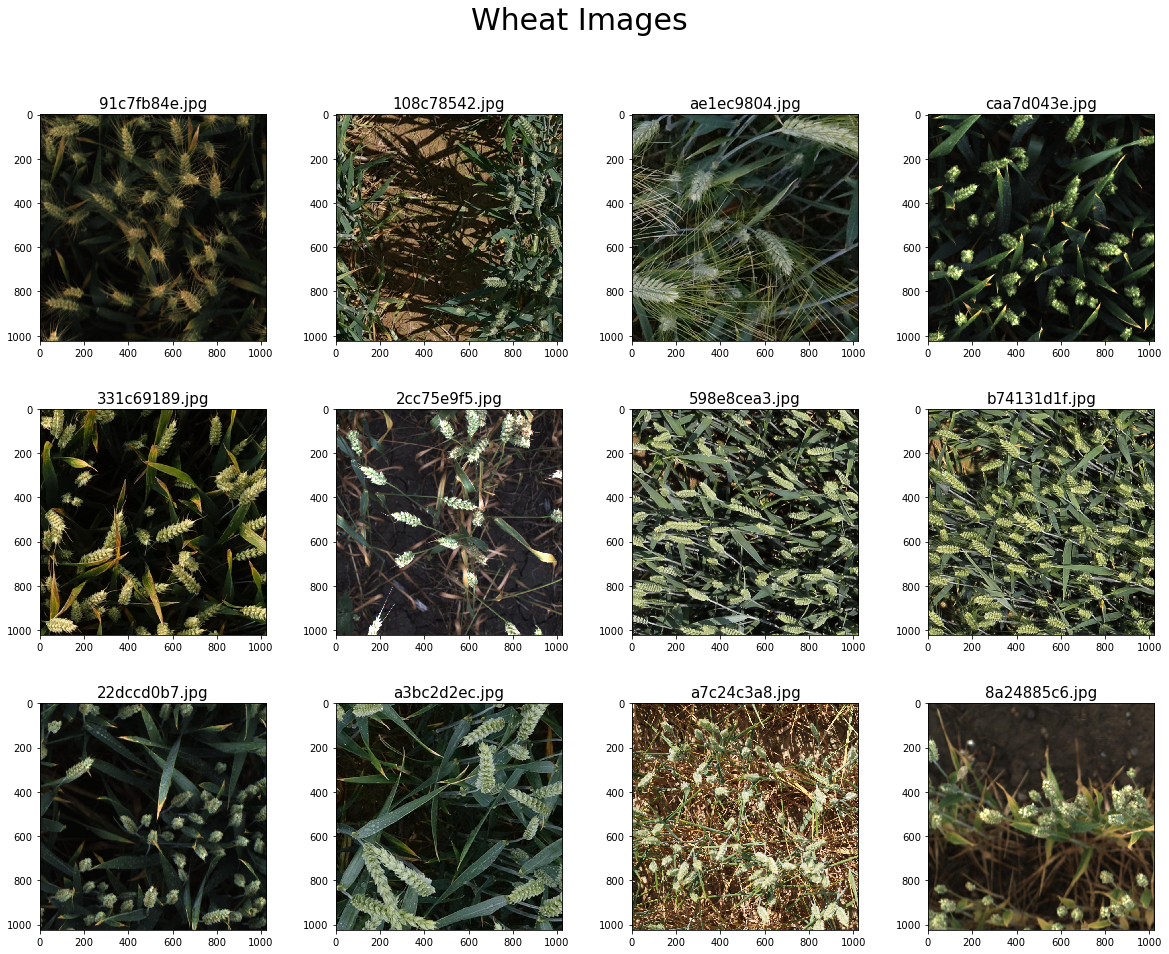

In [20]:
plot_random_images(image_folder_path, image_annotation_file, num = 12)

# Plotting Multiples Images with Bounding Boxes

In object detection with bounding boxes, it is always a good idea to randomly plot some images with their bounding boxes to check for any awry bounding box coordinates. Although I have to say that in this particular competition, there are quite a lot of images with many bounding boxes and hence you have to scrutinize clearly.

In [21]:
def random_bbox_check(image_folder_path, image_annotation_file, num = 12):
    img_dict = {}
    labels = ["wheat", "no wheat"]
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")

    # randomly choose 12 image.
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    image_file_path_list = []

    bbox_list = []
    img_matrix_list = []
    random_image_matrix_list = []
    
    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file)
        img = cv2.imread(image_file_path)[:,:,::-1]  
        height, width, channels = img.shape
        bbox_list.append(img_dict[img_file])
        img_matrix_list.append(img)

    
    final_bbox_list = []
    for bboxes, img in zip(bbox_list, img_matrix_list):
        final_bbox_array = np.array([])
        #bboxes is a 2d array [[...], [...]]
        for bbox in bboxes:
            bbox = np.array(bbox).reshape(1,5)
            final_bbox_array = np.append(final_bbox_array, bbox)
        final_bbox_array = final_bbox_array.reshape(-1,5)
        random_image = draw_rect(img.copy(), final_bbox_array.copy(), color = (255,0,0))
        random_image_matrix_list.append(random_image)
    plot_multiple_img(random_image_matrix_list, title_list = img_files_list, ncols = 4, main_title="Bounding Box Wheat Images")    
    



The images' names are ['4ce73a46c.jpg' 'cb256df87.jpg' 'fa060c1f8.jpg' '0da996869.jpg'
 'f05830c46.jpg' 'f4ce08038.jpg' '3a1c78a92.jpg' '02f0fe2ca.jpg'
 'dc1c9be0d.jpg' 'de941b2fc.jpg' 'b5e726c10.jpg' '3753c58f7.jpg']


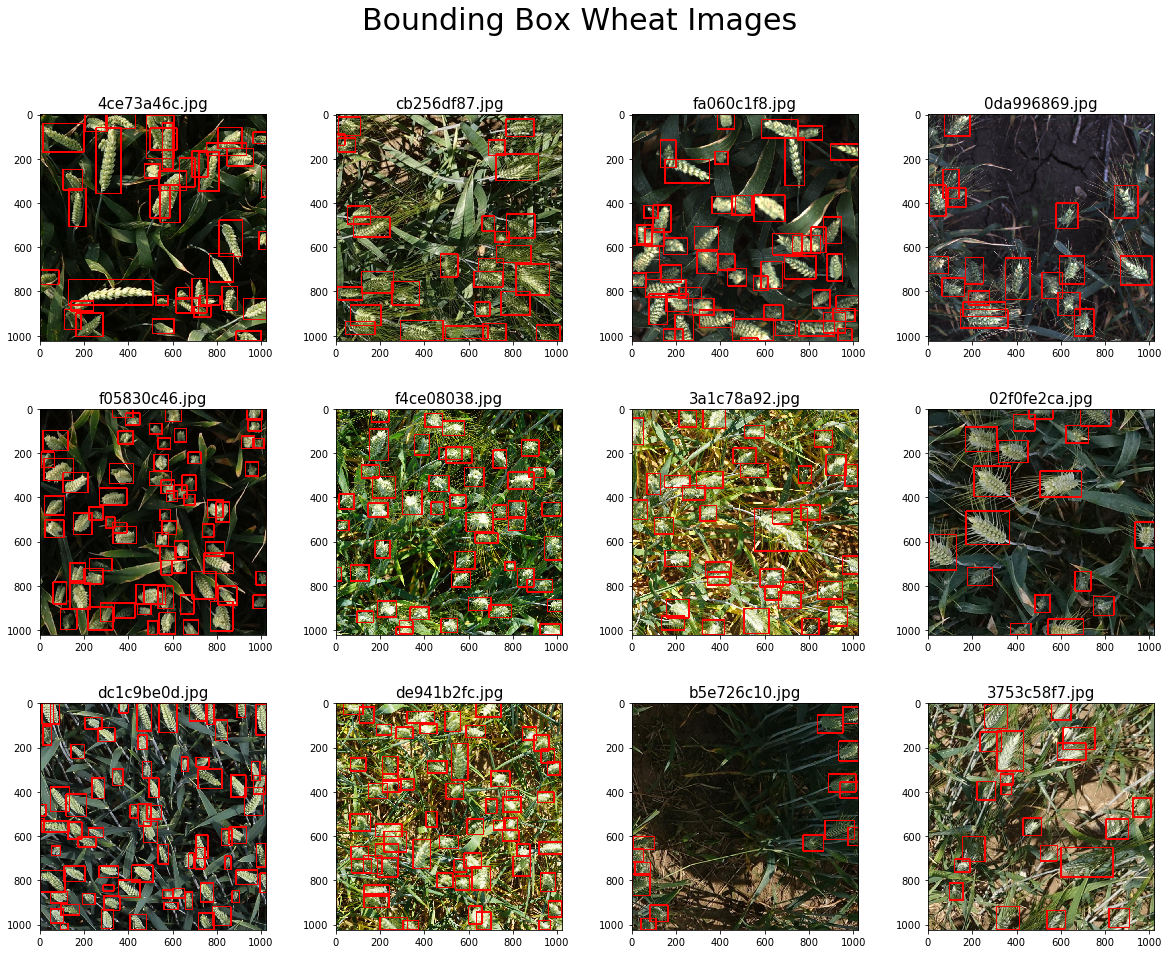

In [22]:
random_bbox_check(image_folder_path, image_annotation_file)

# Augmentations

Augmentation is an important technique to artifically boost your data size. In particular, when the dataset is small, augmentation prior to training the model will help the network to learn better.

In [23]:
# Albumentations
import albumentations as A

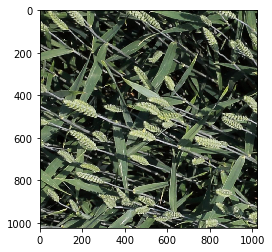

In [24]:
image_folder_path = "/kaggle/input/global-wheat-detection/train/"
chosen_image = cv2.imread(os.path.join(image_folder_path, "8c05f24c4.jpg"))[:,:,::-1]
plt.imshow(chosen_image)

Below are some snippets of augmentation types you can use, interestingly, Albumentation offers `RandomSunFlare` and `RandomFog`; although all the images seem to be taken in a very good lighting, but it might not be that bad an idea since in the real world, images of wheat may taken in different weather conditions.

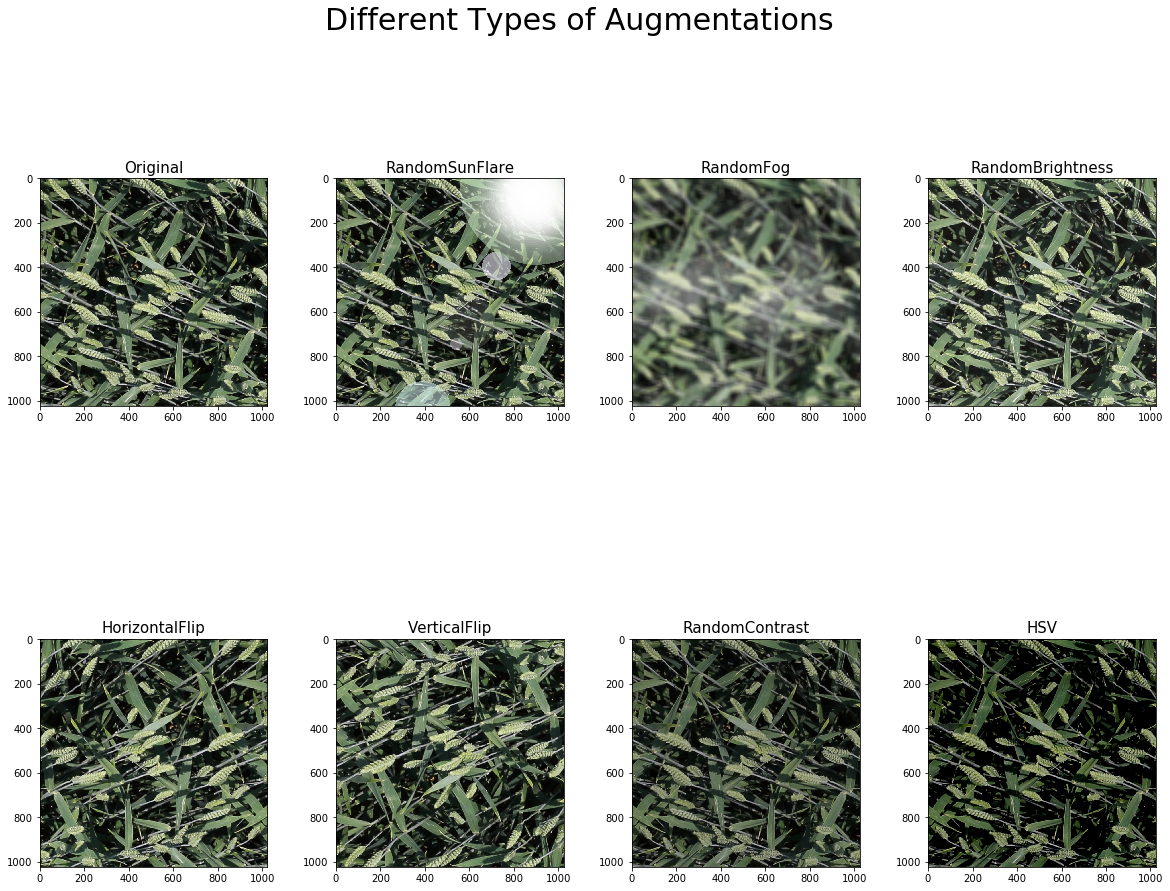

In [25]:
albumentation_list = [A.RandomSunFlare(p=1),A.RandomFog(p=1), A.RandomBrightness(p=1),A.HorizontalFlip(p=1),A.VerticalFlip(p=1), A.RandomContrast(limit = 0.5,p = 1), A.RandomBrightness(p=1), 
                       A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","RandomSunFlare","RandomFog","RandomBrightness","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV"]

##reminder of helper function
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()
    
plot_multiple_img(img_matrix_list, titles_list, ncols = 4,main_title="Different Types of Augmentations")

 **If you liked the visualizations, please upvote to motivate me further and stay tuned for the next kernel which will be on training the models.**